In [49]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

import rasterio
import rasterio.features
from rasterio.enums import Resampling

In [48]:
def load_asap_phenology(file_name, lon_min=22, lon_max=48, lat_min=-18, lat_max=15):
    data_xr = xr.open_dataset(
        "C:/Users/janz/Documents/University HU/Master-Thesis-Project/data/raw_source/crop calendar/ASAP/" + file_name)
    
    # Convert the coordinates to float32
    data_xr = data_xr.assign_coords({
        'x': data_xr['x'].astype(np.float32),
        'y': data_xr['y'].astype(np.float32)
    })
    
    if lon_min is not None and lat_max is not None and lon_max is not None and lat_min is not None:
        # Select the window
        data_xr = data_xr.sel(x=slice(lon_min, lon_max), y=slice(lat_max, lat_min))
    
    return data_xr




In [50]:
def load_asap_phenology(file_name, lon_min=22, lon_max=48, lat_min=-18, lat_max=15):
    with rasterio.open("C:/Users/janz/Documents/University HU/Master-Thesis-Project/data/raw_source/crop calendar/ASAP/" + file_name) as data_src:
        if lon_min is not None and lat_max is not None and lon_max is not None and lat_min is not None:
            # Compute the window of the raster to be read based on the geographical bounds
            window = data_src.window(lon_min, lat_min, lon_max, lat_max)
            data = data_src.read(1, window=window)
            transform = data_src.window_transform(window)
        else:
            crop_mask = data_src.read(1)
            transform = data_src.transform

        crs = data_src.crs
    return data, transform, crs

### Number of seasons

In [72]:
nr_seasons, _, _ = load_asap_phenology("phenonseasons_v03.tif")
two_season_mask = nr_seasons == 2
#print(nr_season_xr.dims)

In [74]:
sos_1, transform, crs = load_asap_phenology("phenos1_v03.tif")
eos_1, transform, crs = load_asap_phenology("phenoe1_v03.tif")
sos_2, transform, crs = load_asap_phenology("phenos2_v03.tif")
eos_2, transform, crs = load_asap_phenology("phenoe2_v03.tif")

In [90]:

# Apply the mask to set values to NaN where the mask is True
masked_sos_2 = np.where(~two_season_mask, np.nan, sos_2)
masked_sos_2 = np.where(masked_sos_2 > 200, np.nan, masked_sos_2)
masked_eos_2 = np.where(~two_season_mask, np.nan, eos_2)
masked_eos_2 = np.where(masked_eos_2 > 200, np.nan, masked_eos_2)

In [116]:
sos_3 = np.where(two_season_mask, sos_2, sos_1)
sos_3 = np.where(sos_3 > 200, np.nan, sos_3)

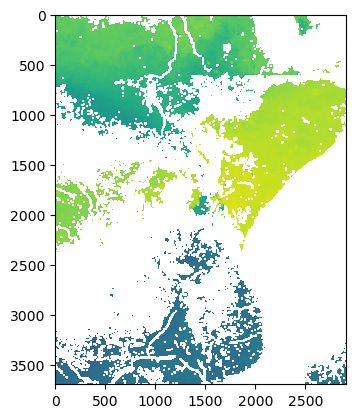

In [118]:
plt.imshow(sos_3)
plt.savefig("test_sos3.jpeg", dpi=1200)

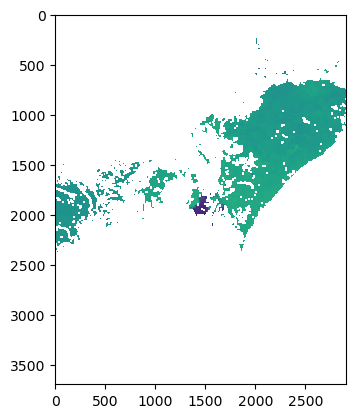

In [92]:
plt.imshow(masked_eos_2)

(array([[ 705., 1792., 1026., ...,    0.,    0.,  173.],
        [ 706., 1765., 1079., ...,    0.,    0.,  146.],
        [ 697., 1760., 1079., ...,    0.,    0.,  160.],
        ...,
        [ 411.,  107.,  616., ...,    0.,    0., 2562.],
        [ 379.,  123.,  618., ...,    0.,    0., 2576.],
        [ 380.,  111.,  601., ...,    0.,    0., 2604.]]),
 array([ 10. ,  34.5,  59. ,  83.5, 108. , 132.5, 157. , 181.5, 206. ,
        230.5, 255. ]),
 <a list of 2912 BarContainer objects>)

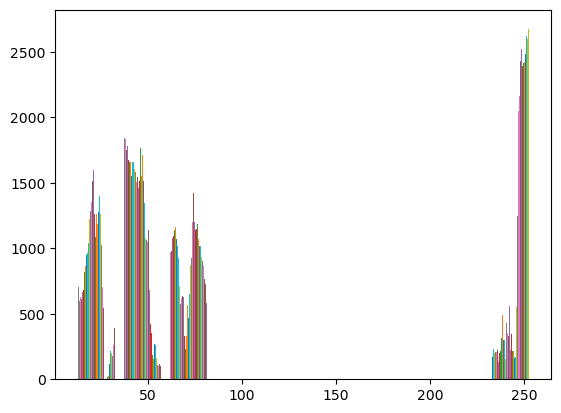

In [105]:
plt.hist(sos_3)

In [64]:
sos_xr

array([[ 55,  55,  55, ..., 251, 251, 251],
       [ 55,  55,  55, ..., 252, 252, 251],
       [ 55,  55,  55, ..., 251, 251, 251],
       ...,
       [ 32,  32,  32, ...,  33,  33,  34],
       [ 32,  32,  32, ...,  33,  33,  33],
       [ 32,  32,  32, ...,  33,  33,  34]], dtype=uint8)

In [54]:
two_season_mask_xr = nr_season_xr == 2

In [45]:
sos_xr.x[:10].values

array([22.      , 22.008928, 22.017857, 22.026785, 22.035715, 22.044643,
       22.053572, 22.0625  , 22.071428, 22.080357], dtype=float32)

In [47]:
two_season_mask_xr.x[:10].values

array([22.000004, 22.008932, 22.017862, 22.02679 , 22.035719, 22.044647,
       22.053576, 22.062504, 22.071432, 22.080362], dtype=float32)

In [22]:
# Align the datasets
sos_xr, two_season_mask_xr = xr.align(sos_xr, two_season_mask_xr, join='inner')

# Set values to NaN in aligned_data_xr where aligned_mask_xr is True
masked_sos_xr = sos_xr.where(~two_season_mask_xr, np.nan)

ValueError: zero-size array to reduction operation minimum which has no identity

In [83]:
# Define the window boundaries
lat_min, lat_max = -18, 15
lon_min, lon_max = 22, 48

# Select the window
#nr_season_xr = nr_season_xr.sel(x=slice(lon_min, lon_max), y=slice(lat_max, lat_min))

In [ ]:
# Plot the windowed data
fig, ax = plt.subplots()
nr_season_xr.band_data.plot(ax=ax)

# Set the aspect of the plot to be equal
ax.set_aspect('equal', 'box')
plt.title('Occurence of two seasons')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Start of the season

In [44]:
sos_xr = load_asap_phenology("phenos2_v03.tif")
print(sos_xr.dims)

Frozen({'band': 1, 'x': 2913, 'y': 3697})


In [6]:
def my_dekade(x):
    return np.where(x > 36, x % 36 + 36 * (x % 36 == 0), x)

# Apply the function to each value in the DataArray
sos_xr = xr.apply_ufunc(my_dekade, sos_xr.band_data)

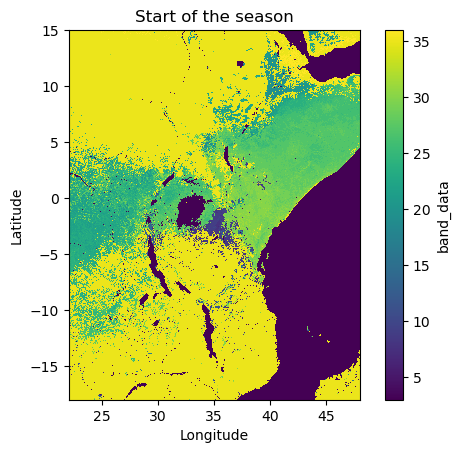

In [59]:
# Plot the windowed data
fig, ax = plt.subplots()
sos_xr.plot(ax=ax)

# Set the aspect of the plot to be equal
ax.set_aspect('equal', 'box')
plt.title('Start of the season')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig("test_sos2_asap.jpeg" ,dpi=1800)
plt.show()

In [7]:
nr_season_xr.band_data == 2.

<xarray.DataArray 'band_data' (band: 1, y: 14673, x: 40320)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 75.0 74.99 74.98 74.97 ... -55.98 -55.99 -56.0
    spatial_ref  int32 ...

In [16]:
nr_season_xr.dims

Frozen({'band': 1, 'x': 40320, 'y': 14673})

In [15]:
sos_xr.dims

Frozen({'band': 1, 'x': 40320, 'y': 14673})

In [17]:
sos_xr = sos_xr.where(nr_season_xr.band_data == 2., np.nan)

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',)

In [42]:
# Set values > 36 to NaN since 36 is the last dekade
sos_xr = sos_xr.where(sos_xr <= 36)



In [49]:
36 % 36


0